## plotting synoptic charts with python

In this notebook, we will plot synoptic charts derived from vector magnetic magnetic field data taken with the NASA Solar Dynamics Observatory (SDO) Helioseismic and Magnetic Imager (HMI) instrument. To do this, we'll query the [Joint Science Operations Center](http://jsoc.stanford.edu/) (JSOC) database, where these data reside, using a JSON API. Then we will plot these data using `mpld3`, a python library that generates javascript internally. <br>

A synoptic chart maps the entire Sun throughout a Carrington rotation; as such, it is represented in the Carrington Longitude and Sine Latitude coordinate system. Synoptic charts can be calculated from both line-of-sight and vector magnetic field data. [Liu et al. (2017)](http://adsabs.harvard.edu/abs/2017SoPh..292...29L) computed synoptic charts for all vector magnetic field data taken with HMI since 2010.<br>

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt
import matplotlib.colors as mcol
from astropy.io import fits
import math
import sunpy.map
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we'll execute a JSON query using the `json` and `urllib` modules to read some metadata and find the location of the FITS data segments. The HMI synoptic chart data is computed using C [modules](http://jsoc.stanford.edu/cvs/JSOC/proj/mag/synop/apps/) that takes the JSOC Data Record Managment System (DRMS) series [hmi.M_720s](http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.M_720s) as an input. <br> 

In [2]:
# first get the most recent Carrington rotation
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.B_synoptic[$]&op=rs_list&key=CAR_ROT,CUNIT1,CUNIT2&seg=Br"
response = urllib.urlopen(url)
data = json.loads(response.read())
car_rot = data['keywords'][0]['values'][0]
cunit1 = data['keywords'][1]['values'][0]
cunit2 = data['keywords'][2]['values'][0]
filename = data['segments'][0]['values'][0]
url = "http://jsoc.stanford.edu"+filename
br = sunpy.map.Map(url)

# print some information
print "The file is for Carrington Rotation "+car_rot+"."

The file is for Carrington Rotation 2188.


To label the axes correctly, we need to know the value of `CUNIT1` and `CUNIT2`, which are the units of the x and y dimensions, respectively.

In [3]:
# Determine the units for this map
print 'CUNIT1 is in',cunit1,"."
print 'CUNIT2 is in',cunit2,"."

CUNIT1 is in degree .
CUNIT2 is in Sine Latitude .


From `CUNIT1` we understand that the units of longitude are in degrees. [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T) says: "At the start of each Carrington rotation, L<sub>0</sub> [the Carrington Longitude] = 360&deg; and steadily decreases until it reaches L<sub>0</sub> = 0&deg;." Thus time in this synoptic map is represented from right to left -- i.e. the beginning of the Carrington period is at 360&deg and the end of the Carrington period is at 0&deg;. <br>

From `CUNIT2` we understand that the units of latitude are in the sine of the angle. This is a convenient measure because in the Carrington Cylindrical Equal Area projection, "latitude pixels are equally spaced in the sine of the angle." (See [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T); Section 5.5). However we can also plot straight latitude, although the pixel size will not be the same across all latitudes:

In [4]:
ytick_latitude = []
ytick_normalize = []
for i in range(19):
    calculation = math.sin((np.pi/18)*(i-9.0))
    ytick_latitude.append(calculation)
    ytick_normalize.append((calculation+1)*720.)

Now we can plot:

In [5]:
# load the color map
colors = np.loadtxt('HMI_MagColor_256.txt')
colormap_customized = mcol.ListedColormap(colors)

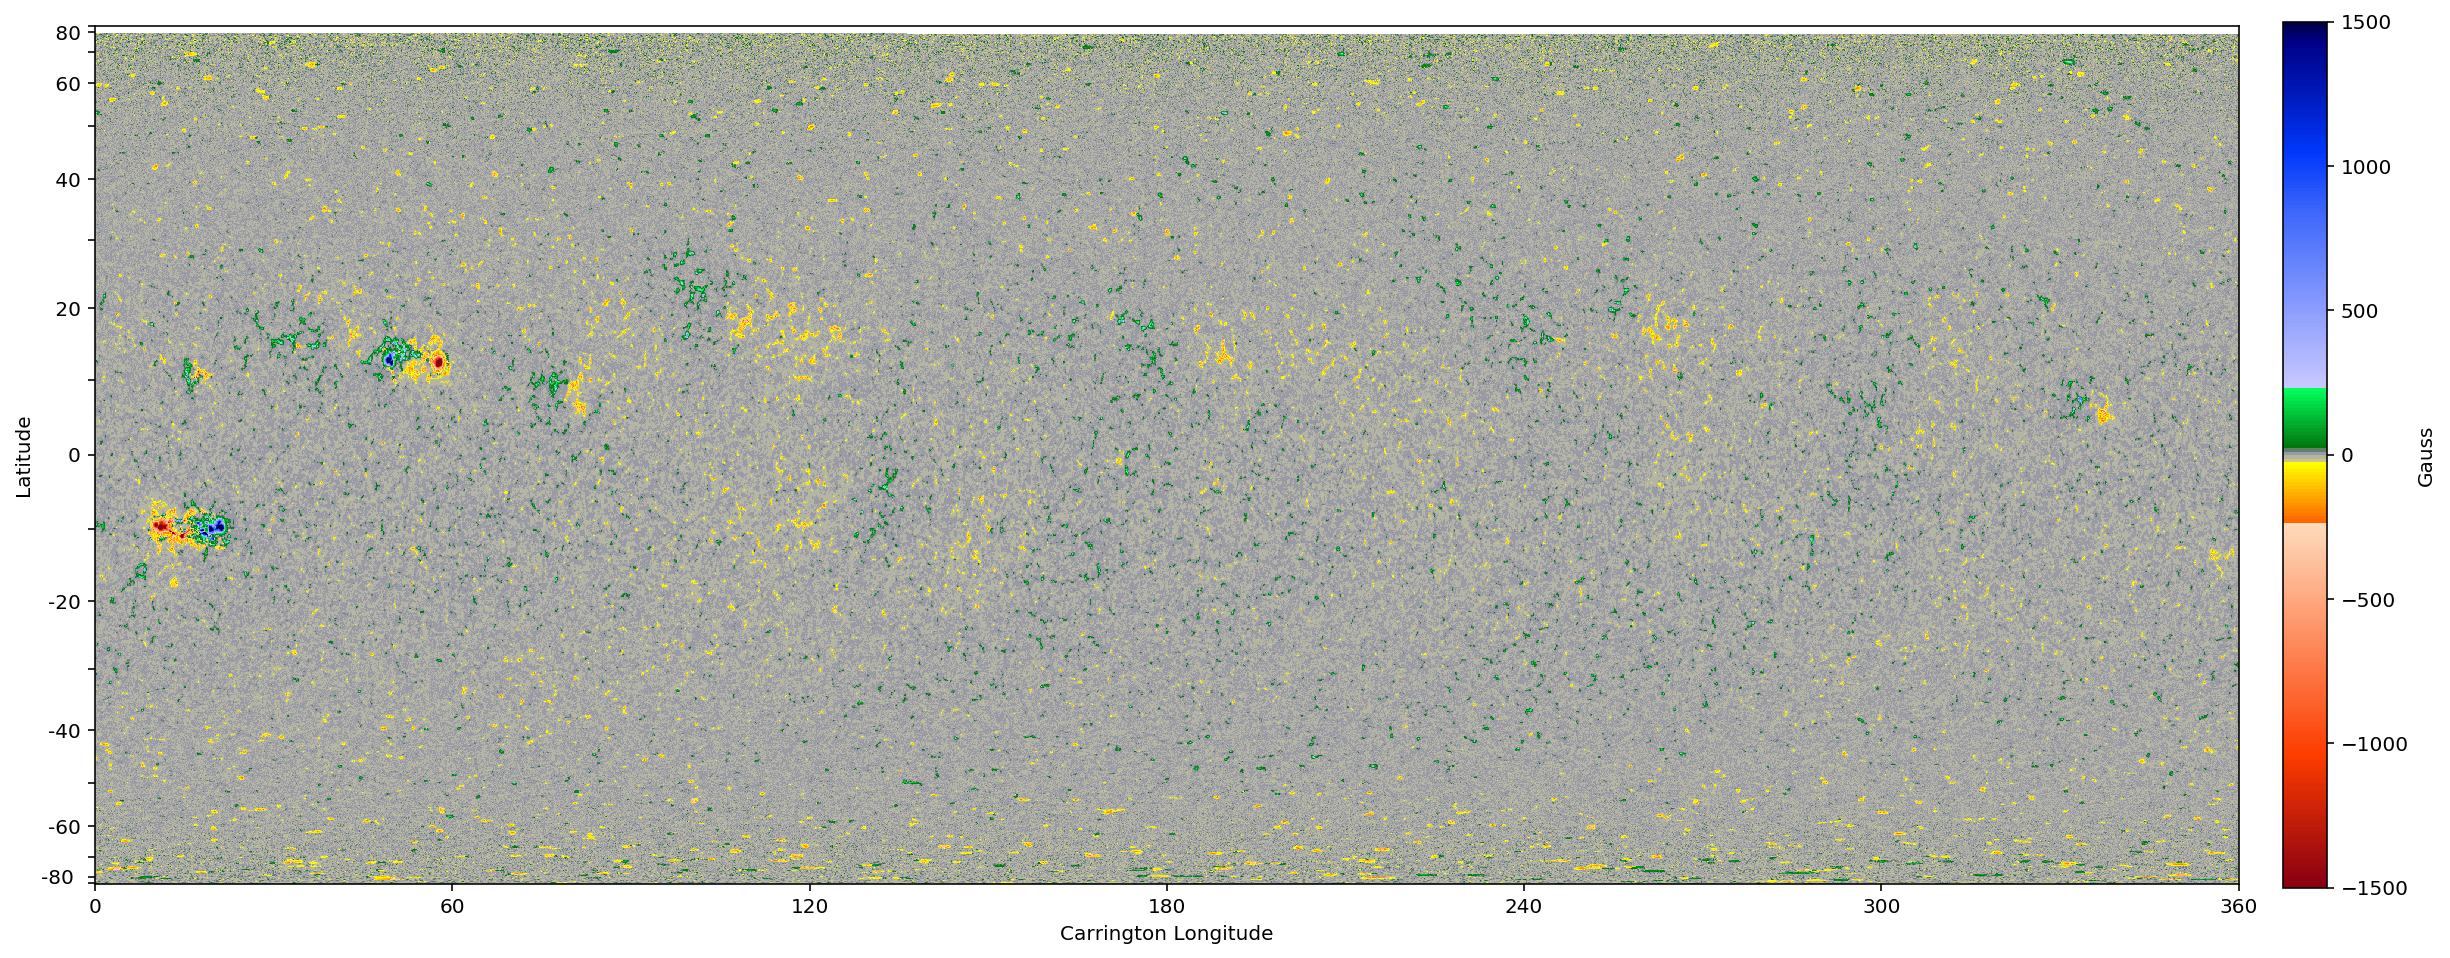

In [6]:
# make the plot
fig, ax = plt.subplots(1,1)
plt.imshow(br.data,cmap=colormap_customized,vmin=-1500,vmax=1500,origin='lower')

# label the x-axis 
xlabels = [label.get_text() for label in ax.get_xticklabels()]
xlocations = list(ax.get_xticks())
xlabels = [0,60,120,180,240,300,360]
xlocations = [0,600,1200,1800,2400,3000,3600]
ax.set_xticklabels(xlabels)
ax.set_xticks(xlocations)

# Create the latitude labels on the right-hand side of the plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]
ylocations = ytick_latitude
ylabels=[' ','-80 ',' ','-60',' ','-40',' ','-20',' ','0',' ',' 20',' ',' 40',' ',' 60',' ',' 80',' ']
ylocations = ytick_normalize
ax.set_yticklabels(ylabels)
ax.set_yticks(ylocations)
ax.set_ylabel('Latitude')

# Create the sine latitude labels instead (if desired)
#ylabels = [label.get_text() for label in ax.get_yticklabels()]
#ylocations = list(ax.get_yticks())
#ylabels = [-1,0,1]
#ylocations = [0,720,1440]
#ax.set_yticklabels(ylabels)
#ax.set_yticks(ylocations)
#ax.set_ylabel('Sine Latitude')

ax.set_xlabel('Carrington Longitude')
plt.colorbar(fraction=0.0194,pad=0.02,label='Gauss')
fig.set_size_inches(20,10)